###  데이터 로드
 - 데이터 출처 : https://www.kaggle.com/datasets/sjleshrac/airlines-customer-satisfaction

In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import warnings

# 경고 메시지를 무시하도록 설정하기
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Invistico_Airline.csv')

### 데이터 전처리하기

#### ■ 결측치 처리하기 

In [4]:
# SimpleImputer 객체로 결측치 대체하기
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
df["Arrival Delay in Minutes"] = mean_imputer.fit_transform(df[["Arrival Delay in Minutes"]])

#### ■ 데이터 인코딩

In [5]:
# object 컬럼 타입을 string 타입으로 변경하기
cols = ['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']
df[cols] = df[cols].astype(str)

In [6]:
# 범주형 데이터를 수치값으로 변경하기
df['satisfaction'].replace(['dissatisfied','satisfied'], [0,1], inplace=True)

In [7]:
# 순서형 인코딩(Ordinal Encoding)하기
categories = pd.Categorical(
    df['Class'], 
    categories= ['Eco', 'Eco Plus', 'Business'], 
    ordered=True)
labels, unique = pd.factorize(categories, sort=True)
df['Class'] = labels

In [8]:
# 원핫 인코딩(One Hot Encoding)하기
cat_cols = ['Gender','Customer Type','Type of Travel']
df = pd.get_dummies(df, columns=cat_cols)

In [9]:
# 데이터 전처리 결과 확인하기
df.head()

,satisfaction,Age,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,...,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel
0,1,65,0,265,0,0,0,2,2,4,...,3,2,0,0.0,1,0,1,0,0,1
1,1,47,2,2464,0,0,0,3,0,2,...,3,2,310,305.0,0,1,1,0,0,1
2,1,15,0,2138,0,0,0,3,2,0,...,4,2,0,0.0,1,0,1,0,0,1
3,1,60,0,623,0,0,0,3,3,4,...,1,3,0,0.0,1,0,1,0,0,1
4,1,70,0,354,0,0,0,3,4,3,...,2,5,0,0.0,1,0,1,0,0,1


In [10]:
# 데이터 타입 확인하기
df.dtypes

satisfaction                           int64
Age                                    int64
Class                                  int64
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
Gender_Female                          uint8
Gender_Male                            uint8
Customer T

#### ■ 데이터셋 분리하기

In [11]:
from sklearn.model_selection import train_test_split

# 데이터셋을 입력(X)과 레이블(y)로 분리하기
X = df.drop(['satisfaction'], axis=1)
y = df['satisfaction'].reset_index(drop=True)

# 데이터셋을 훈련 데이터(train data)와 검증 데이터(validation data)로 분리하기
X_train, X_val, y_train, y_val = train_test_split(X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y)

print(f'훈련 데이터셋 크기 : X_train {X_train.shape}, y_train {y_train.shape}')
print(f'검증 데이터셋 크기 : X_val {X_val.shape}, y_val {y_val.shape}')

훈련 데이터셋 크기 : X_train (103904, 25), y_train (103904,)
검증 데이터셋 크기 : X_val (25976, 25), y_val (25976,)


#### ■ 데이터 스케일링하기

In [12]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화하기
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

print(X_train)

[[0.15384615 0.         0.34502246 ... 1.         1.         0.        ]
 [0.33333333 0.         0.44051587 ... 1.         1.         0.        ]
 [0.48717949 0.         0.26546877 ... 0.         1.         0.        ]
 ...
 [0.35897436 1.         0.31459209 ... 0.         1.         0.        ]
 [0.17948718 0.         0.25010868 ... 0.         0.         1.        ]
 [0.19230769 1.         0.62860455 ... 0.         1.         0.        ]]


### 모델 구성

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(25,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### 모델 학습 환경 설정

In [15]:
# 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법 설정하기
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 

### 모델 학습

In [16]:
# 모델 학습하기
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=128,
          verbose=1, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/100
812/812 [==============================] - 6s 4ms/step - loss: 0.2785 - accuracy: 0.8823 - val_loss: 0.1980 - val_accuracy: 0.9145
Epoch 2/100
812/812 [==============================] - 3s 4ms/step - loss: 0.1870 - accuracy: 0.9216 - val_loss: 0.1649 - val_accuracy: 0.9301
Epoch 3/100
812/812 [==============================] - 3s 4ms/step - loss: 0.1624 - accuracy: 0.9309 - val_loss: 0.1462 - val_accuracy: 0.9367
Epoch 4/100
812/812 [==============================] - 3s 4ms/step - loss: 0.1502 - accuracy: 0.9369 - val_loss: 0.1433 - val_accuracy: 0.9383
Epoch 5/100
812/812 [==============================] - 3s 4ms/step - loss: 0.1408 - accuracy: 0.9398 - val_loss: 0.1303 - val_accuracy: 0.9436
Epoch 6/100
812/812 [==============================] - 3s 4ms/step - loss: 0.1359 - accuracy: 0.9418 - val_loss: 0.1279 - val_accuracy: 0.9446
Epoch 7/100
812/812 [==============================] - 3s 4ms/step - loss: 0.1303 - accuracy: 0.9441 - val_loss: 0.1264 - val_accuracy: 0.9462

### 모델 훈련 과정 시각화

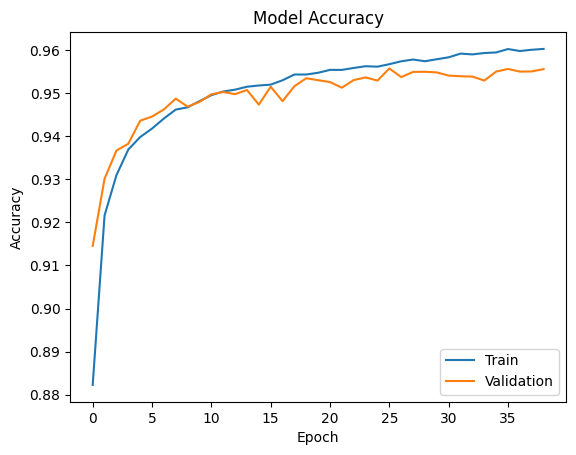

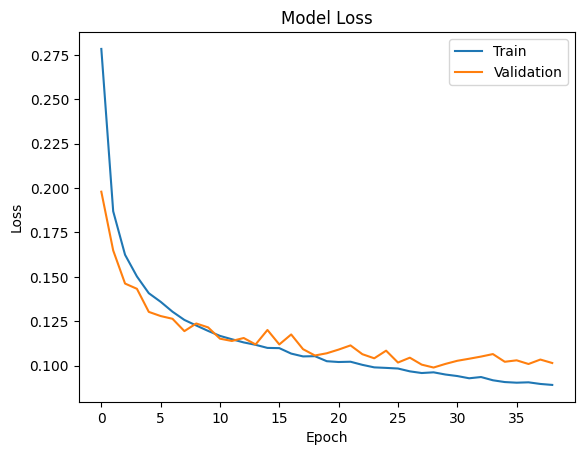

In [17]:
import matplotlib.pyplot as plt

# 훈련 과정 정확도(accuracy) 시각화하기
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# 훈련 과정 손실(loss) 시각화하기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()